In [5]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [1]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get('hf_token')
login(token=hf_token)

In [16]:
!git clone https://huggingface.co/dolphinium/FLUX.1-dev-wikiart-impressionism

Cloning into 'FLUX.1-dev-wikiart-impressionism'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 3), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (65/65), 14.63 KiB | 832.00 KiB/s, done.
Filtering content: 100% (50/50), 830.16 MiB | 51.33 MiB/s, done.


In [17]:
import os
import re
import imageio
from PIL import Image

# Define the path to the samples directory
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_gif_path = "/content/training_progress.gif"

# Function to extract step number from filenames
def extract_step(filename):
    match = re.search(r"_(\d+)_\d+\.jpg", filename)
    return int(match.group(1)) if match else float("inf")

# Get and sort image filenames based on step number
image_filenames = sorted(
    [f for f in os.listdir(samples_dir) if f.endswith(".jpg")],
    key=extract_step
)

# Load images and create a GIF
images = [Image.open(os.path.join(samples_dir, fname)) for fname in image_filenames]
images[0].save(
    output_gif_path,
    save_all=True,
    append_images=images[1:],
    duration=500,  # Set duration per frame (in milliseconds)
    loop=0  # Infinite loop
)

print(f"GIF saved at {output_gif_path}")

GIF saved at /content/training_progress.gif


In [19]:
import os
import re
import imageio
from PIL import Image

# Define paths
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_dir = "/content/gifs"
os.makedirs(output_dir, exist_ok=True)

# Regex pattern to extract step number and prompt ID
pattern = re.compile(r"_(\d{9})_(\d)\.jpg$")

# Organize images by prompt
prompt_images = {0: [], 1: [], 2: [], 3: []}

# Read and categorize images
for filename in sorted(os.listdir(samples_dir)):
    match = pattern.search(filename)
    if match:
        step = int(match.group(1))  # Extract step number
        prompt_id = int(match.group(2))  # Extract prompt ID
        file_path = os.path.join(samples_dir, filename)
        prompt_images[prompt_id].append((step, file_path))

# Generate GIFs for each prompt
for prompt_id, images in prompt_images.items():
    if not images:
        continue

    # Sort images by step number
    images.sort()

    # Load images
    frames = [Image.open(img_path) for _, img_path in images]

    # Save GIF
    gif_path = os.path.join(output_dir, f"prompt_{prompt_id}.gif")
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=500,  # 500ms per frame
        loop=0  # Infinite loop
    )

    print(f"Saved: {gif_path}")

print("GIFs created successfully.")


Saved: /content/gifs/prompt_0.gif
Saved: /content/gifs/prompt_1.gif
Saved: /content/gifs/prompt_2.gif
Saved: /content/gifs/prompt_3.gif
GIFs created successfully.


In [20]:
import os
import re
from PIL import Image, ImageDraw, ImageFont

# Define paths
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_path = "/content/sample_grid.png"

# Define step intervals to include in the grid
steps_to_include = [0, 200, 400, 600, 800, 1000]

# Regex pattern to extract step number and prompt ID
pattern = re.compile(r"_(\d{9})_(\d)\.jpg$")

# Organize images by prompt
prompt_images = {0: {}, 1: {}, 2: {}, 3: {}}

# Read and categorize images
for filename in os.listdir(samples_dir):
    match = pattern.search(filename)
    if match:
        step = int(match.group(1))
        prompt_id = int(match.group(2))
        if step in steps_to_include:
            prompt_images[prompt_id][step] = os.path.join(samples_dir, filename)

# Sort steps
steps_to_include.sort()

# Load images and create grid
img_width, img_height = Image.open(next(iter(prompt_images[0].values()))).size
grid_width = img_width * 6  # 6 steps per row
grid_height = img_height * 4  # 4 prompts per column
grid_img = Image.new("RGB", (grid_width, grid_height), "white")

# Paste images into the grid
for row, prompt_id in enumerate(prompt_images):
    for col, step in enumerate(steps_to_include):
        if step in prompt_images[prompt_id]:
            img_path = prompt_images[prompt_id][step]
            img = Image.open(img_path)
            grid_img.paste(img, (col * img_width, row * img_height))

# Save output image
grid_img.save(output_path)
print(f"Saved grid image: {output_path}")


Saved grid image: /content/sample_grid.png


In [21]:
import os
import re
from PIL import Image, ImageDraw, ImageFont

# Define paths
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_path = "/content/sample_grid_annotated.png"

# Define step intervals to include in the grid
steps_to_include = [0, 200, 400, 600, 800, 1000]

# Regex pattern to extract step number and prompt ID
pattern = re.compile(r"_(\d{9})_(\d)\.jpg$")

# Organize images by prompt
prompt_images = {0: {}, 1: {}, 2: {}, 3: {}}

# Read and categorize images
for filename in os.listdir(samples_dir):
    match = pattern.search(filename)
    if match:
        step = int(match.group(1))
        prompt_id = int(match.group(2))
        if step in steps_to_include:
            prompt_images[prompt_id][step] = os.path.join(samples_dir, filename)

# Sort steps
steps_to_include.sort()

# Load images and create grid
img_width, img_height = Image.open(next(iter(prompt_images[0].values()))).size
grid_width = img_width * 6  # 6 steps per row
grid_height = img_height * 4  # 4 prompts per column
grid_img = Image.new("RGB", (grid_width, grid_height), "white")

# Load font (default PIL font if a better font is not available)
try:
    font = ImageFont.truetype("arial.ttf", 30)
except IOError:
    font = ImageFont.load_default()

# Paste images into the grid with text overlay
for row, prompt_id in enumerate(prompt_images):
    for col, step in enumerate(steps_to_include):
        if step in prompt_images[prompt_id]:
            img_path = prompt_images[prompt_id][step]
            img = Image.open(img_path)
            draw = ImageDraw.Draw(img)

            # Add text overlay (Step & Prompt ID)
            text = f"Step: {step}\nPrompt: {prompt_id}"
            text_x, text_y = 10, 10  # Position of text

            # Draw text with black outline for readability
            draw.text((text_x-1, text_y-1), text, font=font, fill="black")
            draw.text((text_x+1, text_y-1), text, font=font, fill="black")
            draw.text((text_x-1, text_y+1), text, font=font, fill="black")
            draw.text((text_x+1, text_y+1), text, font=font, fill="black")
            draw.text((text_x, text_y), text, font=font, fill="white")

            # Paste image into grid
            grid_img.paste(img, (col * img_width, row * img_height))

# Save output image
grid_img.save(output_path)
print(f"Saved grid image: {output_path}")


Saved grid image: /content/sample_grid_annotated.png


In [23]:
import os
import re
from PIL import Image, ImageDraw, ImageFont

# Define paths
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_path = "/content/sample_grid_annotated_bigger.png"

# Define step intervals to include in the grid
steps_to_include = [0, 200, 400, 600, 800, 1000]

# Regex pattern to extract step number and prompt ID
pattern = re.compile(r"_(\d{9})_(\d)\.jpg$")

# Organize images by prompt
prompt_images = {0: {}, 1: {}, 2: {}, 3: {}}

# Read and categorize images
for filename in os.listdir(samples_dir):
    match = pattern.search(filename)
    if match:
        step = int(match.group(1))
        prompt_id = int(match.group(2))
        if step in steps_to_include:
            prompt_images[prompt_id][step] = os.path.join(samples_dir, filename)

# Sort steps
steps_to_include.sort()

# Load images and create grid
img_width, img_height = Image.open(next(iter(prompt_images[0].values()))).size
grid_width = img_width * 6  # 6 steps per row
grid_height = img_height * 4  # 4 prompts per column
grid_img = Image.new("RGB", (grid_width, grid_height), "white")

# Load a larger font for visibility
try:
    font = ImageFont.truetype("arial.ttf", 100)  # Increased font size
except IOError:
    font = ImageFont.load_default()

# Paste images into the grid with bigger text overlay
for row, prompt_id in enumerate(prompt_images):
    for col, step in enumerate(steps_to_include):
        if step in prompt_images[prompt_id]:
            img_path = prompt_images[prompt_id][step]
            img = Image.open(img_path)
            draw = ImageDraw.Draw(img)

            # Add text overlay (Step & Prompt ID)
            text = f"Step: {step}\nPrompt: {prompt_id}"
            text_x, text_y = 20, 20  # More padding for better visibility

            # Draw bold text with a black outline
            for dx in [-2, 0, 2]:
                for dy in [-2, 0, 2]:
                    draw.text((text_x + dx, text_y + dy), text, font=font, fill="black")
            draw.text((text_x, text_y), text, font=font, fill="white")  # White text in center

            # Paste image into grid
            grid_img.paste(img, (col * img_width, row * img_height))

# Save output image
grid_img.save(output_path)
print(f"Saved grid image: {output_path}")


Saved grid image: /content/sample_grid_annotated_bigger.png


In [26]:
import os
import re
import imageio
from PIL import Image, ImageDraw, ImageFont

# Define paths
samples_dir = "/content/FLUX.1-dev-wikiart-impressionism/samples"
output_dir = "/content/gifs_with_steps_bigger"
os.makedirs(output_dir, exist_ok=True)

# Regex pattern to extract step number and prompt ID
pattern = re.compile(r"_(\d{9})_(\d)\.jpg$")

# Organize images by prompt
prompt_images = {0: [], 1: [], 2: [], 3: []}

# Read and categorize images
for filename in sorted(os.listdir(samples_dir)):
    match = pattern.search(filename)
    if match:
        step = int(match.group(1))  # Extract step number
        prompt_id = int(match.group(2))  # Extract prompt ID
        file_path = os.path.join(samples_dir, filename)
        prompt_images[prompt_id].append((step, file_path))

# Load a large font for visibility
try:
    font = ImageFont.truetype("arial.ttf", 150)  # VERY LARGE TEXT
except IOError:
    font = ImageFont.load_default()

# Generate GIFs for each prompt
for prompt_id, images in prompt_images.items():
    if not images:
        continue

    # Sort images by step number
    images.sort()

    frames = []

    # Load and annotate images
    for step, img_path in images:
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)

        # Add text overlay (Step number)
        text = f"Step: {step}"

        # Get image dimensions
        img_width, img_height = img.size

        # Get text size
        text_width, text_height = draw.textbbox((0, 0), text, font=font)[2:4]

        # Calculate position (CENTER of image)
        text_x = (img_width - text_width) // 2
        text_y = (img_height - text_height) // 2

        # Draw bold text with black outline for visibility
        outline_offset = 5
        for dx in [-outline_offset, 0, outline_offset]:
            for dy in [-outline_offset, 0, outline_offset]:
                draw.text((text_x + dx, text_y + dy), text, font=font, fill="black")

        draw.text((text_x, text_y), text, font=font, fill="white")  # White text in center

        frames.append(img)

    # Save GIF
    gif_path = os.path.join(output_dir, f"prompt_{prompt_id}.gif")
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=500,  # 500ms per frame
        loop=0  # Infinite loop
    )

    print(f"Saved: {gif_path}")

print("GIFs created successfully.")


Saved: /content/gifs_with_steps_bigger/prompt_0.gif
Saved: /content/gifs_with_steps_bigger/prompt_1.gif
Saved: /content/gifs_with_steps_bigger/prompt_2.gif
Saved: /content/gifs_with_steps_bigger/prompt_3.gif
GIFs created successfully.


In [27]:
from google.colab import files
import glob

for file in glob.glob("/content/gifs_with_steps/*.gif"):
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
files.download("/content/sample_grid_annotated.png")
files.download("/content/sample_grid_annotated_bigger.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

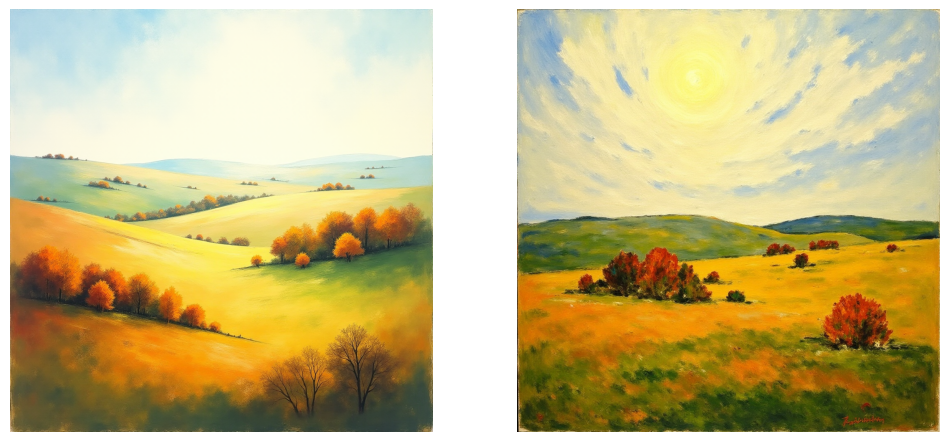

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img1 = mpimg.imread('/content/output-landscape-base.png')
img2 = mpimg.imread('/content/output-landscape-ft.png')

# Create a figure and set of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display images
ax[0].imshow(img1)
ax[0].axis('off')  # Hide axes for the first image
ax[1].imshow(img2)
ax[1].axis('off')  # Hide axes for the second image

# Save the figure as a PNG file
fig.savefig('/content/base_vs_fine_tuned.png', bbox_inches='tight', dpi=300)

# Optionally, display the saved image
plt.show()